In [20]:
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from langchain_anthropic import ChatAnthropic 
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI

from langgraph.constants import Send
from langgraph.graph import START, END, StateGraph

from src.report_maistro.state import ReportStateInput, ReportStateOutput, Sections, ReportState, SectionState, SectionOutputState, Queries
from src.report_maistro.prompts import report_planner_query_writer_instructions, report_planner_instructions, query_writer_instructions, section_writer_instructions, final_section_writer_instructions
from src.report_maistro.configuration import Configuration
from src.report_maistro.utils import tavily_search_async, deduplicate_and_format_sources, format_sections

# LLMs 
planner_model = ChatOpenAI(model=Configuration.planner_model, reasoning_effort="medium") 
writer_model = ChatAnthropic(model=Configuration.writer_model, temperature=0) 

# Nodes
async def generate_report_plan(state: ReportState, config: RunnableConfig):
    """ Generate the report plan """

    # Inputs
    topic = state["topic"]
    feedback = state.get("feedback", None)

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    report_structure = configurable.report_structure
    number_of_queries = configurable.number_of_queries
    tavily_topic = configurable.tavily_topic
    tavily_days = configurable.tavily_days

    # Convert JSON object to string if necessary
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)

    # Generate search query
    structured_llm = writer_model.with_structured_output(Queries)

    # Format system instructions
    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, number_of_queries=number_of_queries)

    # Generate queries  
    results = structured_llm.invoke([SystemMessage(content=system_instructions_query)]+[HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])

    # Web search
    query_list = [query.search_query for query in results.queries]

    # Search web 
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=1000, include_raw_content=False)

    # Format system instructions
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str, feedback=feedback)

    # Generate sections 
    structured_llm = planner_model.with_structured_output(Sections)
    report_sections = structured_llm.invoke([SystemMessage(content=system_instructions_sections)]+[HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")])

    return {"sections": report_sections.sections}

def human_feedback(state: ReportState):
    """ No-op node that should be interrupted on """
    pass

def generate_queries(state: SectionState, config: RunnableConfig):
    """ Generate search queries for a report section """

    # Get state 
    section = state["section"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    number_of_queries = configurable.number_of_queries

    # Generate queries 
    structured_llm = writer_model.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(section_topic=section.description, number_of_queries=number_of_queries)

    # Generate queries  
    queries = structured_llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

async def search_web(state: SectionState, config: RunnableConfig):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""
    
    # Get state 
    search_queries = state["search_queries"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    tavily_topic = configurable.tavily_topic
    tavily_days = configurable.tavily_days

    # Web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await tavily_search_async(query_list, tavily_topic, tavily_days)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(search_docs, max_tokens_per_source=5000, include_raw_content=True)

    return {"source_str": source_str}

def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state 
    section = state["section"]
    source_str = state["source_str"]

    # Format system instructions
    system_instructions = section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=source_str)

    # Generate section  
    section_content = writer_model.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to the section object  
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

def initiate_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report """    
        
    # Check if human feedback
    if state.get("feedback"):
        return "generate_report_plan"
    
    # Kick off section writing in parallel via Send() API for any sections that require research
    else: 
        return [
            Send("build_section_with_web_research", {"section": s}) 
            for s in state["sections"] 
            if s.research
        ]

def write_final_sections(state: SectionState):
    """ Write final sections of the report, which do not require web search and use the completed sections as context """

    # Get state 
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]
    
    # Format system instructions
    system_instructions = final_section_writer_instructions.format(section_title=section.name, section_topic=section.description, context=completed_report_sections)

    # Generate section  
    section_content = writer_model.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to section 
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

def gather_completed_sections(state: ReportState):
    """ Gather completed sections from research and format them as context for writing the final sections """    

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

def initiate_final_section_writing(state: ReportState):
    """ Write any final sections using the Send API to parallelize the process """    

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections", {"section": s, "report_sections_from_research": state["report_sections_from_research"]}) 
        for s in state["sections"] 
        if not s.research
    ]

def compile_final_report(state: ReportState):
    """ Compile the final report """    

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_report": all_sections}

# Report section sub-graph -- 

# Add nodes 
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

# Add edges
section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)

# Outer graph -- 

# Add nodes
builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput, config_schema=Configuration)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("human_feedback", human_feedback)
builder.add_node("build_section_with_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

# Add edges
builder.add_edge(START, "generate_report_plan")
builder.add_edge("generate_report_plan", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_section_writing, ["build_section_with_web_research", "generate_report_plan"])
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

graph = builder.compile(interrupt_before=['human_feedback'])

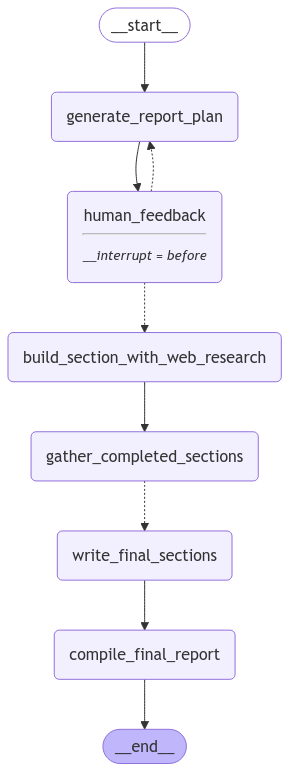

In [21]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
thread = {"configurable": {"thread_id": "4"}}
topic = "Scaling laws for AI next token prediction vs RL on CoT for reasoning"
# Run the graph until the first interruption
async for event in graph.astream({"topic":topic,}, thread, stream_mode="values"):
    # Review
    sections = event.get('sections', '')
    if sections:
        # Print sections in a readable format
        for section in sections:
            print(f"\n📄 {section.name}")
            print(f"{'─' * (len(section.name) + 4)}")
            print(f"Description: {section.description}")
            print(f"Research Required: {'Yes' if section.research else 'No'}")
            print(f"Content Status: {'Empty' if not section.content else 'Filled'}")


📄 Introduction
────────────────
Description: Provide a brief overview of the topic, focusing on what scaling laws are and how they influence next token prediction, and introduce the idea of using reinforcement learning on chain-of-thought (CoT) for improving reasoning.
Research Required: No
Content Status: Empty

📄 Scaling Laws for Next-Token Prediction
──────────────────────────────────────────
Description: Examine the concept of scaling laws in AI, including the key parameters (model size, dataset size, and compute) that influence model performance. Highlight examples like Chinchilla and other research findings on how scaling laws impact next-token prediction.
Research Required: Yes
Content Status: Empty

📄 Reinforcement Learning on Chain-of-Thought (CoT)
────────────────────────────────────────────────────
Description: Define chain-of-thought reasoning and how reinforcement learning can enhance a model’s ability to reason. Cover how RL is used to train large language models to syst

In [37]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [38]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"feedback": 
                            "In Real-World Applications and Case Studies be sure to focus on o1 series models"}, as_node="human_feedback")

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd55be-90ab-6598-8002-a1eef64e6eb4'}}

In [40]:
# Run the graph until the first interruption
async for event in graph.astream(None, thread, stream_mode="values"):
    # Review
    sections = event.get('sections', '')
    if sections:
        # Print sections in a readable format
        for section in sections:
            print(f"\n📄 {section.name}")
            print(f"{'─' * (len(section.name) + 4)}")
            print(f"Description: {section.description}")
            print(f"Research Required: {'Yes' if section.research else 'No'}")
            print(f"Content Status: {'Empty' if not section.content else 'Filled'}")


📄 Introduction
────────────────
Description: Provide a brief overview of the topic, focusing on what scaling laws are and how they influence next token prediction, and introduce the idea of using reinforcement learning on chain-of-thought (CoT) for improving reasoning.
Research Required: No
Content Status: Empty

📄 Scaling Laws for Next-Token Prediction
──────────────────────────────────────────
Description: Examine the concept of scaling laws in AI, including the key parameters (model size, dataset size, and compute) that influence model performance. Highlight examples like Chinchilla and other research findings on how scaling laws impact next-token prediction.
Research Required: Yes
Content Status: Empty

📄 Reinforcement Learning on Chain-of-Thought (CoT)
────────────────────────────────────────────────────
Description: Define chain-of-thought reasoning and how reinforcement learning can enhance a model’s ability to reason. Cover how RL is used to train large language models to syst

In [41]:
# Confirm we are happy
graph.update_state(thread, {"feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd55c4-7f4f-6802-8004-e48178277eb5'}}

In [43]:
# Continue
async for event in graph.astream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
build_section_with_web_research
--Node--
build_section_with_web_research
--Node--
build_section_with_web_research
--Node--
build_section_with_web_research
--Node--
gather_completed_sections
--Node--
write_final_sections
--Node--
write_final_sections
--Node--
compile_final_report


In [44]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Scaling Laws and Chain-of-Thought Reasoning in Language Models

Recent advances in language model development have revealed two distinct but complementary approaches to improving AI reasoning capabilities. Traditional scaling laws, as established by Kaplan and refined by the Chinchilla research, demonstrate that model performance improves predictably with increased compute, parameters, and high-quality training data. However, the emergence of reinforcement learning-based chain-of-thought approaches, exemplified by OpenAI's o1 series, shows that models can develop more sophisticated reasoning by learning to break down complex problems and revise their thinking processes.

This report examines how these approaches intersect and complement each other, analyzing both the fundamental scaling relationships in next-token prediction and the dynamic resource allocation enabled by RL-based chain-of-thought reasoning. Understanding these mechanisms is crucial for advancing AI systems that can tackle increasingly complex reasoning tasks while maintaining computational efficiency.

## How Large Language Models Learn from Data

**Large language models acquire their capabilities through a carefully orchestrated process of exposure to massive text datasets, with performance improvements following predictable scaling laws.** 

The foundational Kaplan scaling laws established that model performance improves as a power-law function of three key factors: compute budget, model size (parameters), and training data volume. However, the 2022 Chinchilla research revealed that previous models were significantly undertrained, finding that optimal training requires about 20 tokens of training data per model parameter.

This led to a key insight: data quality matters as much as quantity. For example, Meta's Llama 3 dramatically exceeded the Chinchilla optimal ratio by training their 8B parameter model on 15 trillion tokens (a ratio of 1,875:1), achieving strong performance with a relatively small model through extended high-quality training.

The learning process involves three critical stages:
- Pre-training on broad internet-scale data to develop general language understanding
- Fine-tuning on curated datasets to enhance specific capabilities
- Reinforcement learning from human feedback to align outputs with desired behavior

### Sources
- Training Compute-Optimal Large Language Models: https://neurips2024-enlsp.github.io/papers/paper_86.pdf
- A brief history of LLM Scaling Laws: https://www.jonvet.com/blog/llm-scaling-in-2025
- Scaling Laws for LLM Pretraining: https://www.jonvet.com/blog/llm-scaling-laws

## Integrating Reinforcement Learning with Chain-of-Thought

**Reinforcement learning (RL) fundamentally enhances chain-of-thought prompting by teaching models to recognize and correct their own reasoning mistakes through iterative feedback loops.** Through large-scale RL algorithms, models learn to hone their reasoning strategies by breaking down complex problems into simpler steps and trying alternative approaches when initial attempts fail.

A key example is OpenAI's o1 model, which uses RL to develop more sophisticated reasoning capabilities. When solving a complex chemistry problem about pH calculations, o1 learns to first identify relevant variables, then systematically work through each calculation step, checking intermediate results for plausibility. If an approach isn't working, the model's RL training enables it to backtrack and attempt a different solution path.

The integration works by having the model generate multiple reasoning attempts for each problem, with rewards assigned based on factors like logical coherence and accuracy of conclusions. This creates a training signal that helps the model learn which reasoning patterns tend to lead to correct solutions. The process leverages "reasoning tokens" - hidden computational steps that aren't visible in the final output but allow the model to refine its internal problem-solving approach.

### Sources:
- Notes on OpenAI's new o1 chain-of-thought models: https://simonwillison.net/2024/Sep/12/openai-o1/
- Learning to reason with LLMs - OpenAI: https://openai.com/index/learning-to-reason-with-llms/
- Open AI Strawberry — The Role of Decision Trees and RL in Chain-of-Thought Reasoning: https://medium.com/autonomous-agents/open-ai-strawberry-the-role-of-decision-trees-and-rl-in-chain-of-thought-reasoning-82bcabcbcbcc

## Next-Token Prediction vs Chain-of-Thought Reasoning

**The fundamental difference between next-token prediction and chain-of-thought reasoning lies in their computational allocation - while traditional next-token models assign similar resources to each token, chain-of-thought approaches enable dynamic resource allocation based on reasoning complexity.**

This distinction becomes clear when examining how each approach handles complex problem-solving. Traditional next-token prediction models like early GPT versions process each token with roughly equal computational effort, regardless of the token's importance to the reasoning process. This can be inefficient, as many tokens serve mainly linguistic fluency rather than advancing logical reasoning.

In contrast, chain-of-thought approaches, particularly those leveraging reinforcement learning, allow models to spend more computational resources on critical reasoning steps. For example, when solving math problems, a chain-of-thought model might dedicate more processing to key algebraic operations while being more efficient with descriptive text.

Recent innovations like OpenAI's o1 models demonstrate how this paradigm shift enables more sophisticated reasoning capabilities - these models can backtrack, revise previous conclusions, and explore multiple solution paths simultaneously, similar to how humans approach complex problems.

### Sources
- Training Large Language Models to Reason in a Continuous Latent Space: https://arxiv.org/html/2412.06769v2
- Notes on OpenAI's new o1 chain-of-thought models: https://simonwillison.net/2024/Sep/12/openai-o1/
- RLHF vs RLAIF for language model alignment: https://www.assemblyai.com/blog/rlhf-vs-rlaif-for-language-model-alignment/

## Scaling Laws and Chain-of-Thought Implementation

**The effectiveness of o1 series models stems from their unique combination of reinforcement learning and chain-of-thought reasoning, which consistently improves with increased compute resources during both training and inference phases.** This represents a significant shift from traditional language models that rely primarily on pre-training and supervised fine-tuning.

A key implementation example comes from the K-9 Mail Android application, where chain-of-thought reasoning achieved 70% accuracy in classifying 54 classes and 184 methods. The system accomplished this by breaking down complex reasoning tasks into explicit intermediate steps, similar to human problem-solving approaches.

The scaling advantages manifest in three critical areas:

* Training compute: Performance improves with more reinforcement learning iterations
* Inference compute: Results get better with additional "thinking time" 
* Reasoning depth: More complex problems become solvable through step-by-step deduction

This implementation approach allows o1 models to tackle previously intractable problems, particularly in STEM fields. For instance, on International Mathematical Olympiad qualification exams, GPT-4 solved only 13% of problems correctly, while the o1 reasoning model achieved 83% accuracy through its scaled chain-of-thought capabilities.

### Sources
- Scaling of Search and Learning: A Roadmap to Reproduce o1 from Reinforcement Learning Perspective: https://www.researchgate.net/publication/387184187_Scaling_of_Search_and_Learning_A_Roadmap_to_Reproduce_o1_from_Reinforcement_Learning_Perspective
- How OpenAI's O1 Series Stands Out Redefining AI Reasoning: https://medium.com/@researchgraph/how-openais-o1-series-stands-out-redefining-ai-reasoning-9e499937139e

## Key Findings and Implications

The integration of reinforcement learning with chain-of-thought reasoning represents a significant advancement over traditional next-token prediction approaches, fundamentally changing how language models process and solve complex problems. Our analysis reveals several critical insights about this evolution in AI capabilities.

Key Developments in Language Model Architecture:

* Scaling laws now emphasize quality over quantity, with Meta's Llama 3 achieving superior results through extended high-quality training (1,875:1 token-to-parameter ratio)
* Chain-of-thought models enable dynamic resource allocation based on reasoning complexity, unlike traditional fixed-compute approaches
* RL-enhanced reasoning allows models to backtrack, revise conclusions, and explore multiple solution paths simultaneously
* Real-world implementations show dramatic improvements in complex problem-solving, with o1 models achieving 83% accuracy on mathematical olympiad problems compared to GPT-4's 13%

The path forward suggests focusing on optimizing the integration of RL with chain-of-thought reasoning, particularly in domains requiring sophisticated problem-solving capabilities. This approach promises to unlock new applications in STEM fields and other areas requiring complex analytical reasoning.